In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import random
import math
from scipy.stats.stats import pearsonr
from scipy.stats.stats import ttest_ind
from scipy.stats import chi2_contingency
from statsmodels.formula.api import ols
from sklearn import tree
from sklearn.tree import _tree
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from pprint import pprint

%matplotlib inline
plt.style.use('ggplot')

C:\Users\lynnm\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Read the data into a Pandas data frame and display some rows

In [2]:
chocolate = pd.read_csv("flavors_of_cacao.csv")
chocolate.head()

,Company (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


## Exploratory Data Analysis

Let's explore this data to see what we can find out about it. As we may want to clean the data as we go, I'll make a copy of it, so I can refer back to the original data if necessary.

In [3]:
chocolateOriginal = chocolate.copy()
chocolateOriginal.head()

,Company (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


These column names are rather cumbersome, so let's simplify them

In [4]:
chocolate.columns = ["Company","SpecificOrigin","Ref","ReviewDate","CocoaPercent","Location","Rating","BeanType","BroadOrigin"]

### Basic Descriptive Statistics

Firstly, check the data types of these columns

In [5]:
chocolate.dtypes

Company            object
SpecificOrigin     object
Ref                 int64
ReviewDate          int64
CocoaPercent       object
Location           object
Rating            float64
BeanType           object
BroadOrigin        object
dtype: object

Let's have a look at the column statistics ...

In [6]:
chocolate.describe()

,Ref,ReviewDate,Rating
count,1795.000000,1795.000000,1795.000000
mean,1035.904735,2012.325348,3.185933
std,552.886365,2.927210,0.478062
min,5.000000,2006.000000,1.000000
25%,576.000000,2010.000000,2.875000
50%,1069.000000,2013.000000,3.250000
75%,1502.000000,2015.000000,3.500000
max,1952.000000,2017.000000,5.000000


So the review date is a year betweeen 2006 and 2017, the references are integers between 5 and 1952, the rating has a mean of 3.19 and a median of 3.25

And the string columns ...

In [7]:
chocolate.describe(exclude=[np.number])

,Company,SpecificOrigin,CocoaPercent,Location,BeanType,BroadOrigin
count,1795,1795,1795,1795,1794,1794
unique,416,1039,45,60,41,100
top,Soma,Madagascar,70%,U.S.A.,,Venezuela
freq,47,57,672,764,887,214


One immediately obvious issue is that we have several string, or categorical columns with large cardinality domains. Many machine learning algorithms require categorical variables to be converted to a set of binary variables (one for each value after the first) - or do this implicitly. This would add almost 1700 variables to the dataset. As we only have 1795 observations, we will almost certainly overfit our model if we use all these variables as they are.

So, let's explore the data to see what feature engineering can be done.

#### Chocolate Ratings

C:\Users\lynnm\Anaconda3\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


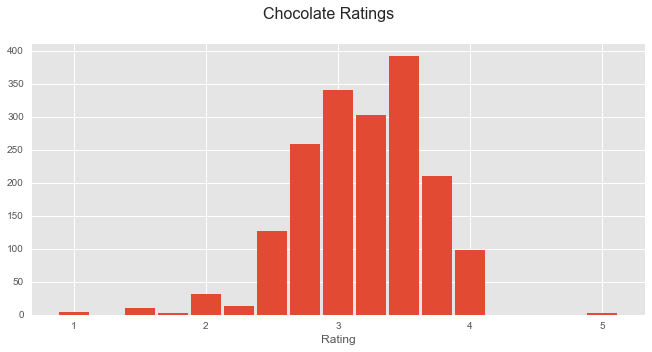

In [8]:
fig, ax = plt.subplots(1,1,figsize=(11, 5))
g1 = sns.distplot(chocolate.Rating, kde=False, bins=np.arange(1, 5.5, 0.25),
                  hist_kws={"rwidth": 0.9, "align": "left", "alpha": 1.0})
sns.plt.suptitle("Chocolate Ratings", fontsize=16)
fig.show()

The ratings are slightly skewed to the left - with a number of low-rated chocolates. There is a slight bi-modality wth peaks at 3 and 3.5, but this may simply indicate a reluctance by reviewers to use the 1/4 ratings (1.75 and 2.25 are similarly lower than would be expected), rather than two distinct groupings.

Which are the best chocolates?

In [9]:
chocolate[chocolate["Rating"] == 5]

,Company,SpecificOrigin,Ref,ReviewDate,CocoaPercent,Location,Rating,BeanType,BroadOrigin
78,Amedei,Chuao,111,2007,70%,Italy,5.0,Trinitario,Venezuela
86,Amedei,Toscano Black,40,2006,70%,Italy,5.0,Blend,


And which are the worst chocolates?

In [10]:
chocolate[chocolate["Rating"] <= 1]

,Company,SpecificOrigin,Ref,ReviewDate,CocoaPercent,Location,Rating,BeanType,BroadOrigin
326,Callebaut,Baking,141,2007,70%,Belgium,1.0,,Ecuador
437,Claudio Corallo,Principe,252,2008,100%,Sao Tome,1.0,Forastero,Sao Tome & Principe
465,Cote d' Or (Kraft),Sensations Intense,48,2006,70%,Belgium,1.0,,
1175,Neuhaus (Callebaut),Dark,135,2007,73%,Belgium,1.0,,


### Feature Engineering

#### Cocoa Percentage

The Cocoa Percentage is a string ... let's convert it to a number and as it's a percentage we'll also convert it to a proportion

In [11]:
chocolate.CocoaPercent = chocolate.CocoaPercent.apply(lambda x : float(x.rstrip("%"))/100.0)
chocolate.describe()

,Ref,ReviewDate,CocoaPercent,Rating
count,1795.000000,1795.000000,1795.000000,1795.000000
mean,1035.904735,2012.325348,0.716983,3.185933
std,552.886365,2.927210,0.063231,0.478062
min,5.000000,2006.000000,0.420000,1.000000
25%,576.000000,2010.000000,0.700000,2.875000
50%,1069.000000,2013.000000,0.700000,3.250000
75%,1502.000000,2015.000000,0.750000,3.500000
max,1952.000000,2017.000000,1.000000,5.000000


Import some visualisation libraries, so we can plot some charts to help us understand the data

So the cocoa percentage ranges from 42% to 100%, with a mean of 71.7% and median 70%. How are the values distributed?

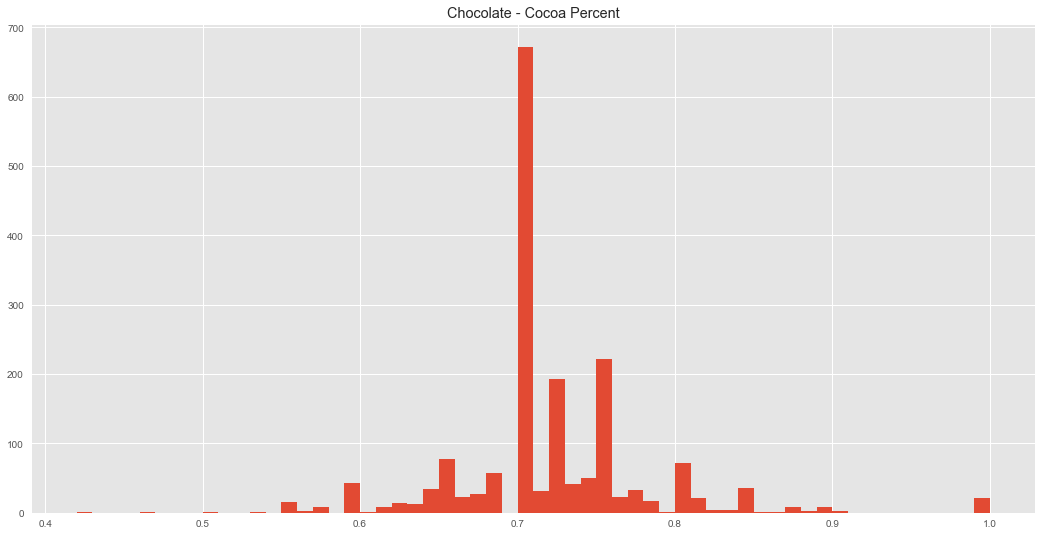

In [12]:
g = chocolate.CocoaPercent.hist(bins=58, figsize=(18,9))
plt.title("Chocolate - Cocoa Percent")
plt.show(g)

The most common value is 70%, and quite a few samples have 72% and 75% cocoa. The distribution is not symmetric and has quite long tails (below 55% and above 90%).

#### Review Date

Count the number of reviews for each year and plot the distribution

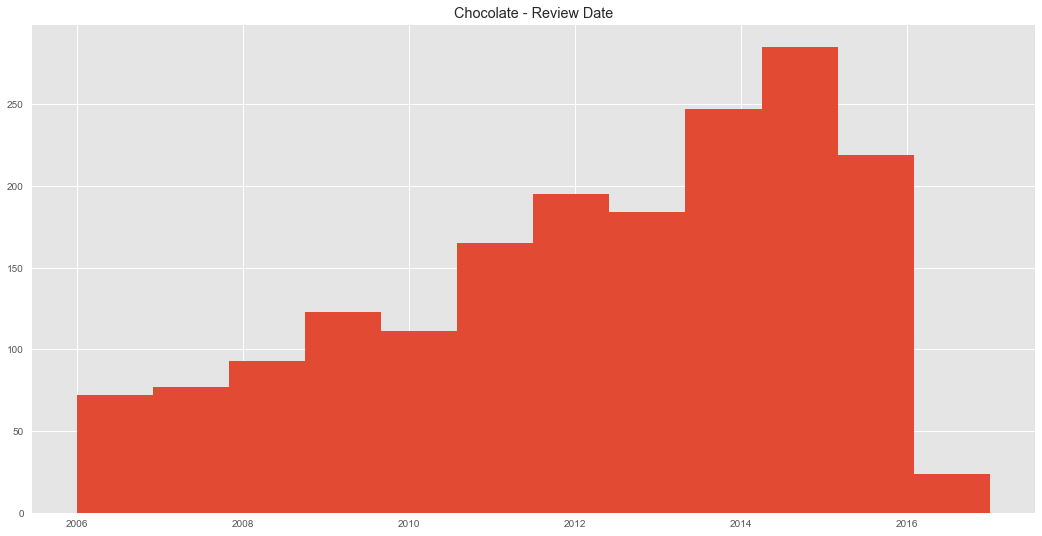

In [13]:
chocolate.ReviewDate.value_counts()
g = chocolate.ReviewDate.hist(bins=12, figsize=(18,9))
plt.title("Chocolate - Review Date")
plt.show(g)

The number of reviews per year increases most years until 2016. The low number of review in 2017 may indicate data collection stopped early 2017.

#### Ref

The range of ref values is less than the total number of reviews, so this is obviously not a unique field. How many unique values are there and how often is each one used?

In [14]:
ref = chocolate.Ref.copy()
print("Number of unique ref values:" + str(ref.nunique()))
ref.sort_values(inplace=True)
print("\nCount of ref values by number of occurrences")
print(pd.DataFrame(ref.value_counts()).groupby('Ref').Ref.count())

Number of unique ref values:440

Count of ref values by number of occurrences
Ref
1       8
2      18
3      46
4     311
5      16
6      16
7      12
8       9
9       3
10      1
Name: Ref, dtype: int64


There are 440 unique refs. Each ref occurs between one and ten times (i.e. 8 refs occur just once, 311 occur four times and 1 occurs ten times).

The column metadata for this dataset (https://www.kaggle.com/rtatman/chocolate-bar-ratings/data) says this is linked to when the data is entered in the database, so it is likely to be closely related to the review date, so lets compare these.

,ReviewDate,count,minRef,maxRef,uniqueRef
0,2006,72,5,105,14
1,2007,77,111,196,18
2,2008,93,199,308,30
3,2009,123,311,464,23
4,2010,111,464,615,24
5,2011,165,623,793,40
6,2012,195,793,1007,55
7,2013,184,1007,1193,48
8,2014,247,1197,1442,63
9,2015,285,1446,1708,67


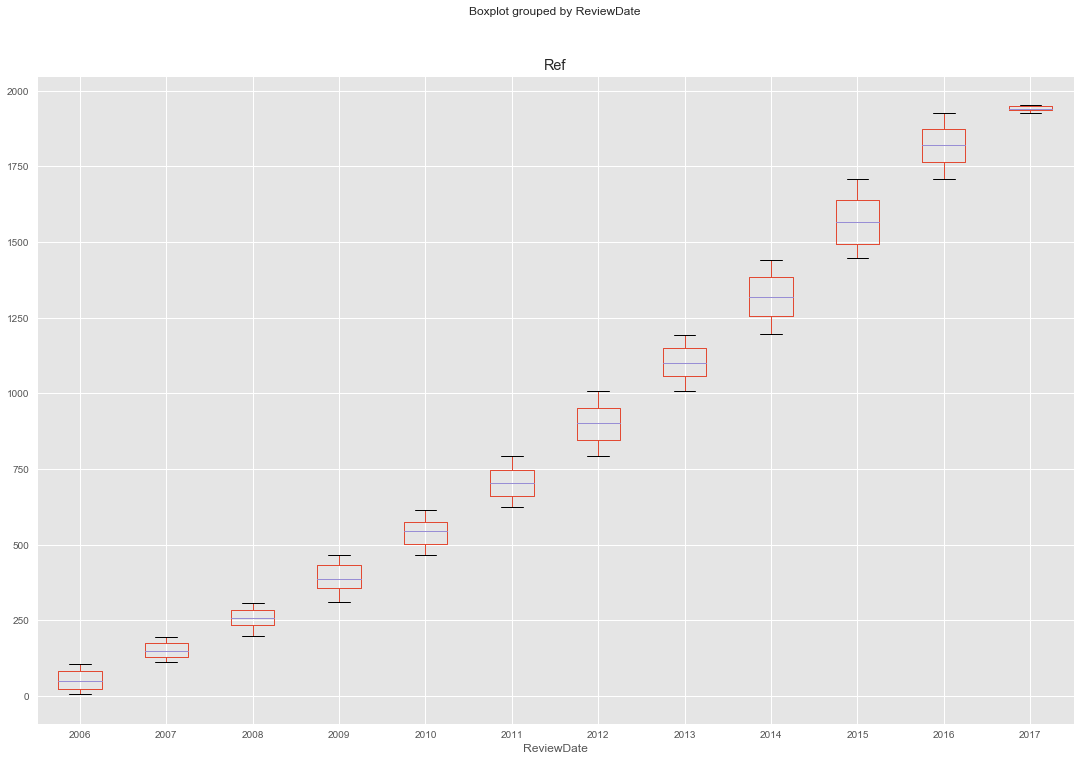

In [15]:
ref = chocolate.groupby('ReviewDate').Ref
ref = pd.concat([ref.count(), ref.min(), ref.max(), ref.nunique()], axis=1).reset_index()
ref.columns = ['ReviewDate','count','minRef','maxRef','uniqueRef']
g = chocolate.boxplot(column="Ref", by="ReviewDate", figsize=(18,12))
ref

The samples with the same ref are generally for the same year, with the occasional ref spanning two years (e.g. 464 spans 2009 and 2010 and 1928 spans 2016 and 2017).

#### Company

There are 416 different chocolate companies in the dataset, which is too many to use with only 1795 samples. Is there any way to combine any of the companies?

Let's look at the top 50 companies by number of samples:

C:\Users\lynnm\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


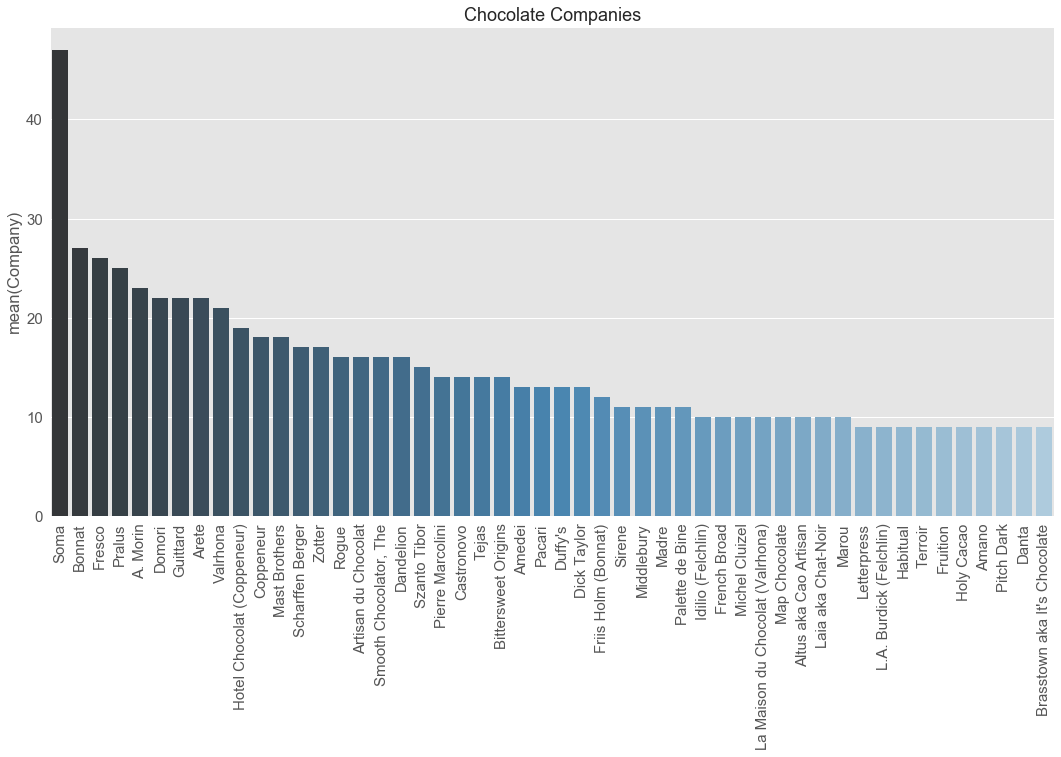

In [16]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = plt.subplots(figsize=(18, 9))
g = sns.barplot(x=chocolate.Company.value_counts().index[0:50], y=chocolate.Company.value_counts()[0:50], palette="Blues_d")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("Chocolate Companies")
plt.show(g)

There are a few that could be related - for instance according to the metadata in values like "Hotel Chocolat (Copperneur)" the maker is "Copperneur", so we could extract the maker - and assume the company is the maker where there isn't one.

In [17]:
chocolate["Company"] = chocolate.Company.apply(lambda x: re.split("\(|aka ",x.rstrip(")"))[-1])

And now we'll only keep the ones with more than 20 observations - set the others to "other"

In [18]:
company = chocolate[["Company","Ref"]].groupby("Company").count().reset_index() #sort_values(by="Ref", ascending=False).reset_index()
company["newCompany"] = company.apply(lambda x: x.Company if x.Ref > 20 else "other", axis=1)
company

,Company,Ref,newCompany
0,A. Morin,28,A. Morin
1,AMMA,6,other
2,Acalli,2,other
3,Adi,4,other
4,Ah Cacao,1,other
5,Alain Ducasse,5,other
6,Alexandre,4,other
7,Amano,9,other
8,Amazona,2,other
9,Ambrosia,6,other


In [19]:
chocolate = chocolate.merge(company[["Company","newCompany"]], how="left", on="Company")

C:\Users\lynnm\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


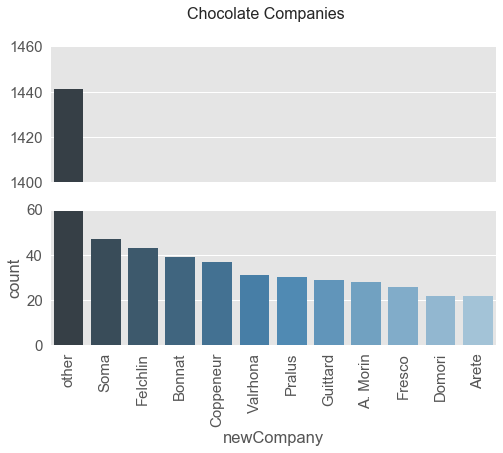

In [20]:
fig,(ax1,ax2) = plt.subplots(2, 1, sharex=True)

g1 = sns.countplot(chocolate.newCompany, order=chocolate.newCompany.value_counts().index, palette="Blues_d", ax=ax1)
g1.set_xticklabels('')
g1.set_xlabel('')
g1.set_ylabel('')
g1.set_ylim(1400,1460)

g2 = sns.countplot(chocolate.newCompany, order=chocolate.newCompany.value_counts().index, palette="Blues_d", ax=ax2)
g2.set_xticklabels(g2.get_xticklabels(), rotation=90)
g2.set_ylim(0,60)

plt.suptitle("Chocolate Companies", fontsize=16)
plt.subplots_adjust(hspace=0.2)

#### Location

There are 60 locations in the dataset. How are the observations distributed across these locations?

C:\Users\lynnm\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


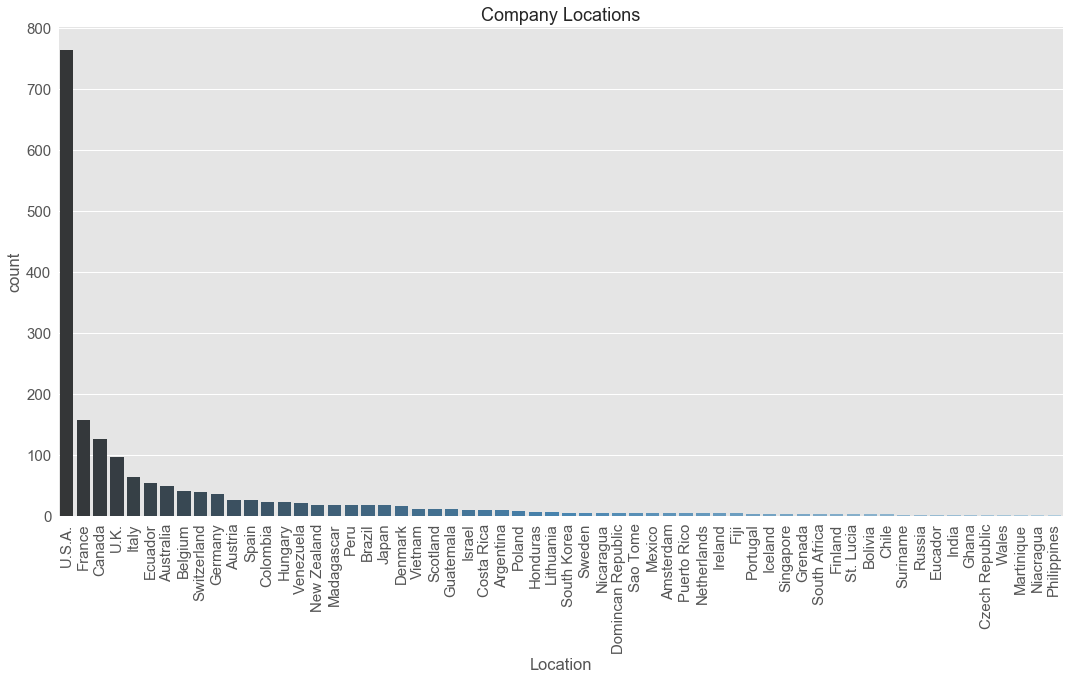

In [21]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = plt.subplots(figsize=(18, 9))
g = sns.countplot(chocolate.Location, order=chocolate.Location.value_counts().index, palette="Blues_d")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("Company Locations")
plt.show(g)

The largest category is the U.S.A, another nine countries countries have more than 30 observations and the remaining 50 have less than 30. Let's combine these smaller locations into a single category.

C:\Users\lynnm\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


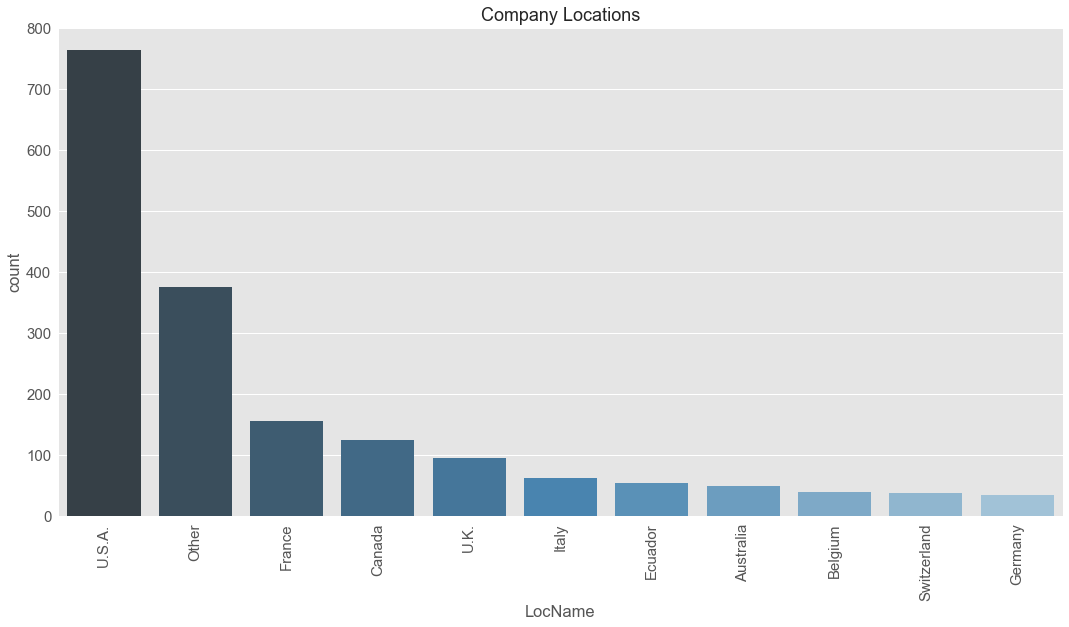

In [22]:
locs = chocolate.Location.value_counts()
chocolate["LocName"] = chocolate.Location.apply(lambda x: "Other" if x in locs[locs < 30].index else x)
#locs[locs > 30].index
chocolate.LocName.value_counts()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = plt.subplots(figsize=(18, 9))
g = sns.countplot(chocolate.LocName, order=chocolate.LocName.value_counts().index, palette="Blues_d")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("Company Locations")
plt.show(g)

The new location column (currently LocName) has 11 categories, with the "Other" category having just under 400 observations.

#### Bean Type

Plot the BeanType distribution 

C:\Users\lynnm\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


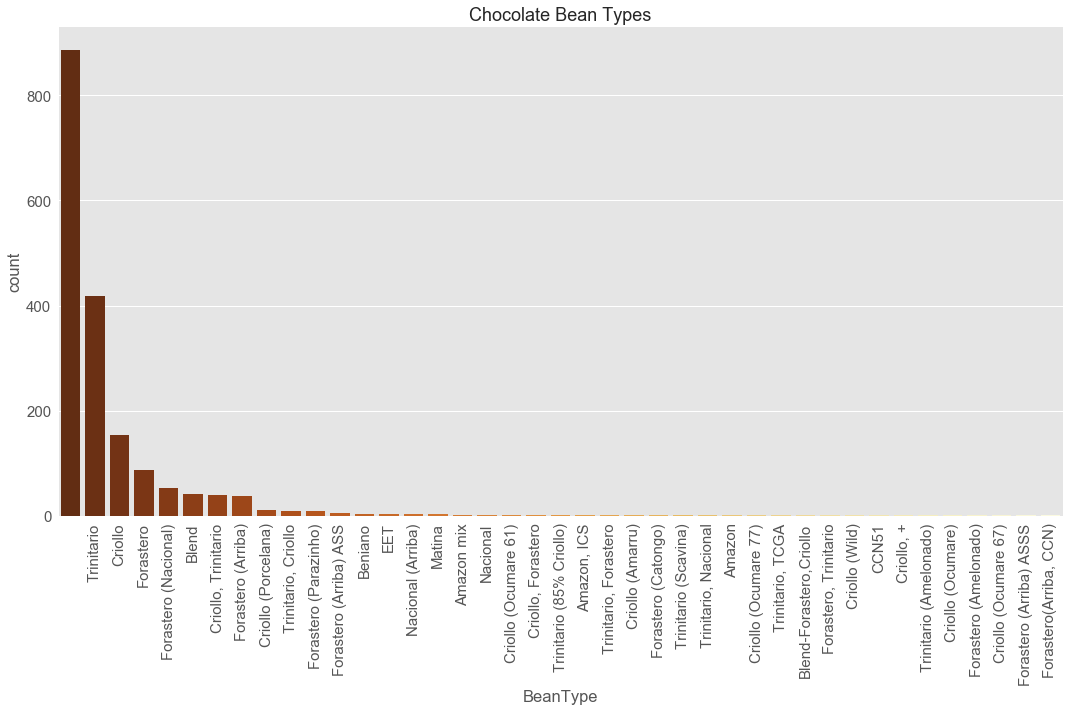

In [23]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

g = plt.subplots(figsize=(18, 9))
g = sns.countplot(chocolate.BeanType, order=chocolate.BeanType.value_counts().index, palette="YlOrBr_r")
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("Chocolate Bean Types")
plt.show(g)

The largest group has no category name, then there are the Trinitario, Criollo, and Forastero cocoa beans, which according to various websites make up nearly all the cocoa bean varieties grown. There is the blend category, plus several categories that specify two types of beans, plus some that appear to be identifying a sub-type.

To simplify this, create a new Bean Type feature (called BeanT for now) as follows:
- Convert nans and other empty strings to "not-specified"
- Convert categories with two bean types to "Blend". As there are quite a few Criollo blends (in particular Criollo/Trinitario) keep these separate from the other blends in case this is significant.
- Remove any sub-type.

In [24]:
chocolate['BeanT'] = chocolate.BeanType.replace(np.nan, 'not-specified', regex=True).replace('\xa0', 'not-specified').apply(
    lambda x : ("Blend-Criollo" if "Criollo" in re.split(" |,|\)",str(x)) else "Blend") if any(
        word in x for word in ['Blend',',']) else x).apply(lambda x : (x.split()[0]))
chocolate.describe(exclude=[np.number])

,Company,SpecificOrigin,Location,BeanType,BroadOrigin,newCompany,LocName,BeanT
count,1795,1795,1795,1794,1794,1795,1795,1795
unique,370,1039,60,41,100,12,11,12
top,Soma,Madagascar,U.S.A.,,Venezuela,other,U.S.A.,not-specified
freq,47,57,764,887,214,1441,764,888


So that has reduced the number of bean types to 12.

What bean types do we have now?

In [25]:
#chocolate.BeanT.unique()
chocolate.groupby('BeanT').BeanT.count()

BeanT
Amazon             3
Beniano            3
Blend             49
Blend-Criollo     52
CCN51              1
Criollo          171
EET                3
Forastero        194
Matina             3
Nacional           5
Trinitario       423
not-specified    888
Name: BeanT, dtype: int64

We have the three main bean types, the two blends and the "not-specified" category, plus six very small categories. Lets combine all the small categories together, as individually they do not have enough samples.

C:\Users\lynnm\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
C:\Users\lynnm\Anaconda3\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


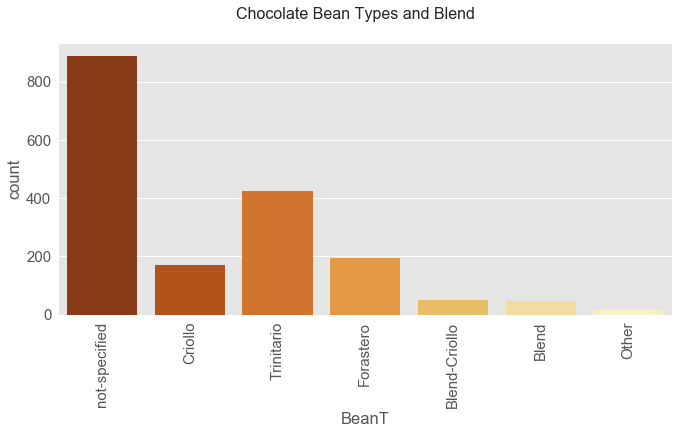

In [26]:
chocolate['BeanT'] = chocolate['BeanT'].apply(
    lambda x: "Other" if x in ["Amazon","Beniano","CCN51","EET","Matina","Nacional"] else x)

fig, ax = plt.subplots(1,1,figsize=(11, 5))
g1 = sns.countplot(chocolate.BeanT, palette="YlOrBr_r") #, ax=ax[0])
g1.set_xticklabels(g1.get_xticklabels(), rotation=90)
sns.plt.suptitle("Chocolate Bean Types and Blend", fontsize=16)
fig.show()

In [27]:
chocolate.groupby('BeanT').BeanT.count()

BeanT
Blend             49
Blend-Criollo     52
Criollo          171
Forastero        194
Other             18
Trinitario       423
not-specified    888
Name: BeanT, dtype: int64

#### Specific Origin and Broad Origin

Specific Origin has over 1000 distinct values, which is clearly too many to work with. Can we ignore this and just use the Broad Origin?

Lets have a closer look at the two most common values - Madagascar for Specific Origin and Venezuela for Broad Origin

BroadOrigin has 100 values, with the following distribution:

In [28]:
#chocolate.groupby('SpecificOrigin').SpecificOrigin.count().sort_values(ascending=False).head(10)
print(chocolate.groupby('BroadOrigin').BroadOrigin.count().sort_index())

BroadOrigin
Africa, Carribean, C. Am.         1
Australia                         3
Belize                           49
Bolivia                          57
Brazil                           58
Burma                             1
Cameroon                          1
Carribean                         8
Carribean(DR/Jam/Tri)             1
Central and S. America            4
Colombia                         40
Colombia, Ecuador                 3
Congo                            10
Cost Rica, Ven                    1
Costa Rica                       38
Cuba                             11
DR, Ecuador, Peru                 1
Dom. Rep., Madagascar             1
Domincan Republic                25
Dominican Rep., Bali              1
Dominican Republic              141
Ecuador                         193
Ecuador, Costa Rica               1
Ecuador, Mad., PNG                1
El Salvador                       2
Fiji                              8
Gabon                             1
Ghana           

These are mainly countries, but the data is messy, there are misspellings and multiple abbreviations for the same country. There are regions and continents, and multiple countries. 

Many categories have a very small number of records, and these will need combining to provide useful categories. An obvious way to combine categories with multiple countries is to assume most of the beans are from the first country and ignore the other countries. We'll also fix the spelling mistakes and expand the abbreviations.

In [29]:
chocolate["Origin"] = chocolate.BroadOrigin.replace(np.nan, 'not specified', regex=True).replace(
    '\xa0', 'not specified').str.replace('Dom.*','Dominican Republic').str.replace('Ven.*','Venezuela').apply(
    lambda x: re.split(',|\(|\/|\&|\-',str(x))[0].rstrip().replace('Cost ','Costa ').replace('DR','Dominican Republic').replace(
        'Tobago','Trinidad').replace('Trinidad','Trinidad and Tobago').replace("Carribean","Caribbean"))
print(chocolate.groupby('Origin').Origin.count().sort_index())

Origin
Africa                      1
Australia                   3
Belize                     49
Bolivia                    57
Brazil                     58
Burma                       1
Cameroon                    1
Caribbean                   9
Central and S. America      4
Colombia                   43
Congo                      10
Costa Rica                 39
Cuba                       11
Dominican Republic        169
Ecuador                   195
El Salvador                 2
Fiji                        8
Gabon                       1
Ghana                      37
Gre.                        1
Grenada                    19
Guat.                       1
Guatemala                  28
Haiti                       9
Hawaii                     28
Honduras                   15
India                       4
Indonesia                  17
Ivory Coast                 5
Jamaica                    20
                         ... 
Mad.                        1
Madagascar                146
Mal

That's fixed some and shown a few more ... let's fix these 

In [30]:
chocolate["Origin"] = chocolate.Origin.apply(
    lambda x: x.replace('Gre.','Grenada').replace('Guat.','Guatemala').replace("Hawaii","United States of America").replace(
        'Mad.','Madagascar').replace('PNG','Papua New Guinea').replace('Principe','Sao Tome').replace(
        'Sao Tome','Sao Tome and Principe'))
print(chocolate.groupby('Origin').Origin.count().sort_index())

Origin
Africa                        1
Australia                     3
Belize                       49
Bolivia                      57
Brazil                       58
Burma                         1
Cameroon                      1
Caribbean                     9
Central and S. America        4
Colombia                     43
Congo                        10
Costa Rica                   39
Cuba                         11
Dominican Republic          169
Ecuador                     195
El Salvador                   2
Fiji                          8
Gabon                         1
Ghana                        37
Grenada                      20
Guatemala                    29
Haiti                         9
Honduras                     15
India                         4
Indonesia                    17
Ivory Coast                   5
Jamaica                      20
Liberia                       3
Madagascar                  147
Malaysia                      3
Martinique                    1
M

Ok - that looks better. But we still have some categories with very small numbers of records. If we assume that chocolate beans from countries close together are similar, then combining countries by region and/or continent should be useful.

To help do this, I'll use another Kaggle dataset: the countryContinent.csv dataset from "https://www.kaggle.com/statchaitya/country-to-continent/data"

In [31]:
countriesRaw = pd.read_csv("countryContinent.csv", encoding='iso-8859-1') 
countriesRaw

,country,code_2,code_3,country_code,iso_3166_2,continent,sub_region,region_code,sub_region_code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,142.0,34.0
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,150.0,154.0
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,150.0,39.0
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,2.0,15.0
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,9.0,61.0
5,Andorra,AD,AND,20,ISO 3166-2:AD,Europe,Southern Europe,150.0,39.0
6,Angola,AO,AGO,24,ISO 3166-2:AO,Africa,Middle Africa,2.0,17.0
7,Anguilla,AI,AIA,660,ISO 3166-2:AI,Americas,Caribbean,19.0,29.0
8,Antarctica,AQ,ATA,10,ISO 3166-2:AQ,NaN,NaN,NaN,NaN
9,Antigua and Barbuda,AG,ATG,28,ISO 3166-2:AG,Americas,Caribbean,19.0,29.0


We'll tidy this list up to strip off the extranenous parts of the country (e.g. so we have "Venezuela" instead of "Venezuela (Bolivarian Republic of)"

In [32]:
countries = countriesRaw[["country","sub_region","continent"]]
countries.country = countries.country.apply(lambda x: re.split("\(|\,",x)[0].rstrip())
countries = countries.drop_duplicates()
countries

C:\Users\lynnm\Anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,country,sub_region,continent
0,Afghanistan,Southern Asia,Asia
1,Åland Islands,Northern Europe,Europe
2,Albania,Southern Europe,Europe
3,Algeria,Northern Africa,Africa
4,American Samoa,Polynesia,Oceania
5,Andorra,Southern Europe,Europe
6,Angola,Middle Africa,Africa
7,Anguilla,Caribbean,Americas
8,Antarctica,NaN,NaN
9,Antigua and Barbuda,Caribbean,Americas


Some more updates to the Origin attribute, to match the country and sub-region names used in the Countries dataset

In [33]:
chocolate["Origin"] = chocolate["Origin"] = chocolate.Origin.apply(
    lambda x: x.replace("St.","Saint").replace("Vietnam","Viet Nam").replace("Burma","Myanmar").replace(
        "Ivory Coast","Côte d'Ivoire").replace("West","Western").replace(" and S. "," "))
print(chocolate.groupby('Origin').Origin.count().sort_index())

Origin
Africa                        1
Australia                     3
Belize                       49
Bolivia                      57
Brazil                       58
Cameroon                      1
Caribbean                     9
Central America               4
Colombia                     43
Congo                        10
Costa Rica                   39
Cuba                         11
Côte d'Ivoire                 5
Dominican Republic          169
Ecuador                     195
El Salvador                   2
Fiji                          8
Gabon                         1
Ghana                        37
Grenada                      20
Guatemala                    29
Haiti                         9
Honduras                     15
India                         4
Indonesia                    17
Jamaica                      20
Liberia                       3
Madagascar                  147
Malaysia                      3
Martinique                    1
Mexico                       30
M

Now we can merge the chocolate and countries dataframes to set a sub_region for each country. Then we'll list the ones that haven't matched:

In [34]:
chocolate = chocolate.merge(countries[["country","sub_region"]], how="left", left_on="Origin", right_on="country")
chocolate[chocolate.country.isnull()].groupby("Origin").Origin.count().sort_index()

Origin
Africa              1
Caribbean           9
Central America     4
South America       4
Western Africa      6
not specified      74
Name: Origin, dtype: int64

We'll manually fix up Hawaii. For the others that didn't match, we'll set the sub_region to the Origin. We'll also set the country for the "not specified" rows.

In [35]:
chocolate.loc[chocolate.Origin=="Hawaii","country"] = "United States of America"
chocolate.loc[chocolate.Origin=="Hawaii","sub_region"] = "Northern America"

chocolate.loc[chocolate.country.isnull(),"sub_region"] = chocolate.loc[chocolate.country.isnull(),"Origin"]
chocolate.loc[chocolate.country.isnull(),"country"] = "--"

Now we'll use the sub_region to find the continents ... and fix up "Africa"

In [36]:
regions = countries[["sub_region","continent"]].drop_duplicates()
chocolate = chocolate.merge(regions, how="left", on="sub_region")
chocolate.loc[chocolate.Origin=='Africa',"continent"] = 'Africa'
chocolate.continent = chocolate.continent.replace(np.nan,"other")

In [37]:
print(chocolate[["continent","sub_region","country","Origin"]].groupby(["continent","sub_region","country"]).count())

                                                              Origin
continent sub_region                country                         
Africa    Africa                    --                             1
          Eastern Africa            Madagascar                   147
                                    Tanzania                      34
                                    Uganda                         8
          Middle Africa             Cameroon                       1
                                    Congo                         10
                                    Gabon                          1
                                    Sao Tome and Principe         18
          Western Africa            --                             6
                                    Côte d'Ivoire                  5
                                    Ghana                         37
                                    Liberia                        3
                                  

Next we'll do the rollups by setting all the small country categories to the sub_region

In [38]:
chocCounts = chocolate[["Origin","Ref"]].groupby(["Origin"]).count()
chocCounts.columns = ["countryCount"]
chocRollup = chocolate.merge(chocCounts, how="left", left_on="Origin", right_index=True)[["Origin","sub_region","countryCount"]]
chocolate.Origin = chocRollup.apply(lambda x: x.sub_region if x.countryCount < 28 else x.Origin, axis=1)
print(chocolate[["continent","sub_region","country","Origin"]].groupby(["continent","sub_region","Origin"]).count())

                                                               country
continent sub_region                Origin                            
Africa    Africa                    Africa                           1
          Eastern Africa            Eastern Africa                   8
                                    Madagascar                     147
                                    Tanzania                        34
          Middle Africa             Middle Africa                   30
          Western Africa            Ghana                           37
                                    Western Africa                  18
Americas  Caribbean                 Caribbean                       82
                                    Dominican Republic             169
                                    Trinidad and Tobago             39
          Central America           Belize                          49
                                    Central America                 28
      

And repeat that to set the ones that are still small to the continent

In [39]:
chocCounts = chocolate[["Origin","Ref"]].groupby(["Origin"]).count()
chocCounts.columns = ["countryCount"]
chocRollup = chocolate.merge(chocCounts, how="left", left_on="Origin", right_index=True)[["Origin","continent","countryCount"]]
chocolate.Origin = chocRollup.apply(lambda x: x.continent if x.countryCount < 28 else x.Origin, axis=1)
print(chocolate[["continent","country","Origin"]].groupby(["continent","Origin"]).count())
#print(chocolate[["continent","sub_region","country","Origin"]].groupby(["continent","sub_region","Origin"]).count())

                                    country
continent Origin                           
Africa    Africa                         27
          Ghana                          37
          Madagascar                    147
          Middle Africa                  30
          Tanzania                       34
Americas  Americas                        5
          Belize                         49
          Bolivia                        57
          Brazil                         58
          Caribbean                      82
          Central America                28
          Colombia                       43
          Costa Rica                     39
          Dominican Republic            169
          Ecuador                       195
          Guatemala                      29
          Mexico                         30
          Nicaragua                      60
          Peru                          172
          Trinidad and Tobago            39
          United States of Ameri

This looks good, the only problem is only 5 records have rolled up to "Americas". Find an appropriate category to merge this with.

In [40]:
print(chocolate.loc[chocolate.Origin.str.contains("America"),["Origin","BroadOrigin","country"]].groupby(["Origin","BroadOrigin"]).count())

                                                 country
Origin                   BroadOrigin                    
Americas                 South America                 3
                         South America, Africa         1
                         Suriname                      1
Central America          Central and S. America        4
                         El Salvador                   2
                         Honduras                     15
                         Panama                        7
United States of America Hawaii                       28


So some of our "Central America" records have the original BroadOrigin of "Central and S. America", so this looks like a good candidate. Combine "Americas" and "Central America" into one category and display the final Origin values.

In [41]:
chocolate.loc[chocolate.Origin.isin(["Americas","Central America"]),"Origin"] = "Central and South America"
print(chocolate[["continent","country","Origin"]].groupby(["continent","Origin"]).count())

                                     country
continent Origin                            
Africa    Africa                          27
          Ghana                           37
          Madagascar                     147
          Middle Africa                   30
          Tanzania                        34
Americas  Belize                          49
          Bolivia                         57
          Brazil                          58
          Caribbean                       82
          Central and South America       33
          Colombia                        43
          Costa Rica                      39
          Dominican Republic             169
          Ecuador                        195
          Guatemala                       29
          Mexico                          30
          Nicaragua                       60
          Peru                           172
          Trinidad and Tobago             39
          United States of America        28
          

##### SpecificOrigin

In [42]:
chocolate.SpecificOrigin.describe()

count           1795
unique          1039
top       Madagascar
freq              57
Name: SpecificOrigin, dtype: object

In [43]:
origin = chocolate[['SpecificOrigin', 'Ref']].groupby(['SpecificOrigin']).count().reset_index()
origin[origin.Ref >= 20]

,SpecificOrigin,Ref
312,Dominican Republic,37
334,Ecuador,42
564,Madagascar,57
754,Peru,45
1001,Venezuela,21


There are 1039 SpecificOrigin values, out of 1795 records. Most only occur once and only 5 values have more than 20 observations. There doesn't seem a lot of point doing anything with these - especially as we have the BroadOrigin.

#### Re-Organise Dataframe

Display the current dataframe, original data and new features

In [44]:
chocolate.head()

,Company,SpecificOrigin,Ref,ReviewDate,CocoaPercent,Location,Rating,BeanType,BroadOrigin,newCompany,LocName,BeanT,Origin,country,sub_region,continent
0,A. Morin,Agua Grande,1876,2016,0.63,France,3.75,,Sao Tome,A. Morin,France,not-specified,Middle Africa,Sao Tome and Principe,Middle Africa,Africa
1,A. Morin,Kpime,1676,2015,0.70,France,2.75,,Togo,A. Morin,France,not-specified,Africa,Togo,Western Africa,Africa
2,A. Morin,Atsane,1676,2015,0.70,France,3.00,,Togo,A. Morin,France,not-specified,Africa,Togo,Western Africa,Africa
3,A. Morin,Akata,1680,2015,0.70,France,3.50,,Togo,A. Morin,France,not-specified,Africa,Togo,Western Africa,Africa
4,A. Morin,Quilla,1704,2015,0.70,France,3.50,,Peru,A. Morin,France,not-specified,Peru,Peru,South America,Americas


Re-organise dataframe, keeping just the attributes we want
- Drop Company and replace with newCompany
- Drop SpecificOrigin as this has too many values
- Drop Ref and ReviewDate (if we're going to predict the rating for new types of chocolate we presumably won't have these attributes)
- Keep CocoaPercent
- Drop Location and replace with LocName
- Keep Rating
- Drop BeanType and replace with BeanT
- Drop BroadOrigin and replace with Origin

In [45]:
chocolate=chocolate.loc[:,["Rating", "CocoaPercent", "newCompany", "LocName", "BeanT", "Origin"]]
chocolate.columns = ["Rating","CocoaPercent","Company","Location","BeanType","Origin"]
chocolate.dtypes

Rating          float64
CocoaPercent    float64
Company          object
Location         object
BeanType         object
Origin           object
dtype: object

In [46]:
chocolate.head()

,Rating,CocoaPercent,Company,Location,BeanType,Origin
0,3.75,0.63,A. Morin,France,not-specified,Middle Africa
1,2.75,0.70,A. Morin,France,not-specified,Africa
2,3.00,0.70,A. Morin,France,not-specified,Africa
3,3.50,0.70,A. Morin,France,not-specified,Africa
4,3.50,0.70,A. Morin,France,not-specified,Peru


### Influences on Rating

#### CocoaPercent

Anecdotally, good chocolate is associated with higher percentage of cocoa. Is this correct?

C:\Users\lynnm\Anaconda3\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


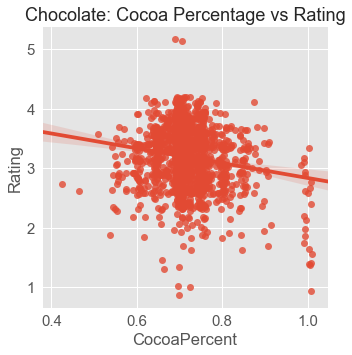

In [47]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
g1 = sns.lmplot(x="CocoaPercent", y="Rating", data=chocolate, y_jitter=0.2, x_jitter=0.01)
plt.title("Chocolate: Cocoa Percentage vs Rating")
fig.show()

That assumption appears to be wrong - there is a clear negative association between Cocoa percent and rating. We can check this using a Pearson's correlation test

In [48]:
pearsonr(chocolate.CocoaPercent, chocolate.Rating)

(-0.16482017762424422, 2.121599928868931e-12)

There is a slight negative correlation (-0.16), but this is significant (2.12e-12).

##### Finding 1:

A higher Cocoa percent is associated with a lower rating

#### Company

Run an ANOVA test to see if the ratings vary by company

In [49]:
comp_lm = ols('Rating ~ Company', data=chocolate).fit()
print(comp_lm.params)
print(sm.stats.anova_lm(comp_lm, typ=2))

Intercept               3.339286
Company[T.Arete]        0.194805
Company[T.Bonnat]       0.070971
Company[T.Coppeneur]   -0.291988
Company[T.Domori]       0.137987
Company[T.Felchlin]     0.067691
Company[T.Fresco]       0.045330
Company[T.Guittard]    -0.106527
Company[T.Pralus]      -0.072619
Company[T.Soma]         0.245821
Company[T.Valrhona]    -0.008641
Company[T.other]       -0.197544
dtype: float64
              sum_sq      df         F        PR(>F)
Company    22.204842    11.0  9.281022  2.217887e-16
Residual  387.802470  1783.0       NaN           NaN


The ANOVA test shows there is a significant variation in the ratings between companies. Visualise the differences using a Boxplot, and order the boxplots by the mean rating.

C:\Users\lynnm\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


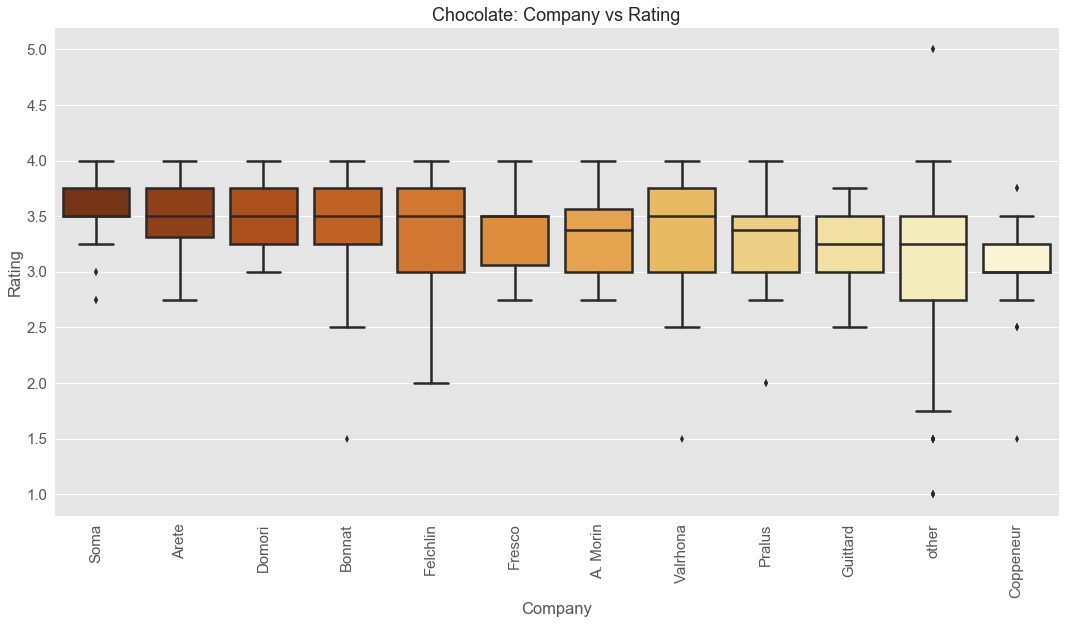

In [50]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = plt.subplots(figsize=(18, 9))
g = sns.boxplot(x=chocolate.Company, y=chocolate.Rating, palette="YlOrBr_r",
                order=chocolate[["Company","Rating"]].groupby("Company").mean().sort_values("Rating", ascending=False).index)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("Chocolate: Company vs Rating")
plt.show(g)

#### Location

Run an ANOVA test to see if the ratings vary by location

In [51]:
loc_lm = ols('Rating ~ Location', data=chocolate).fit()
print(loc_lm.params)
print(sm.stats.anova_lm(loc_lm, typ=2))

Intercept                  3.357143
Location[T.Belgium]       -0.263393
Location[T.Canada]        -0.033143
Location[T.Ecuador]       -0.347884
Location[T.France]        -0.105540
Location[T.Germany]       -0.178571
Location[T.Italy]         -0.031746
Location[T.Other]         -0.171810
Location[T.Switzerland]   -0.015038
Location[T.U.K.]          -0.302455
Location[T.U.S.A.]        -0.203020
dtype: float64
              sum_sq      df         F        PR(>F)
Location   11.098243    10.0  4.963353  3.962880e-07
Residual  398.909069  1784.0       NaN           NaN


The ANOVA test shows there is a significant variation in the ratings between locations. Visualise the differences using a Boxplot, and order the boxplots by the mean rating.

C:\Users\lynnm\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


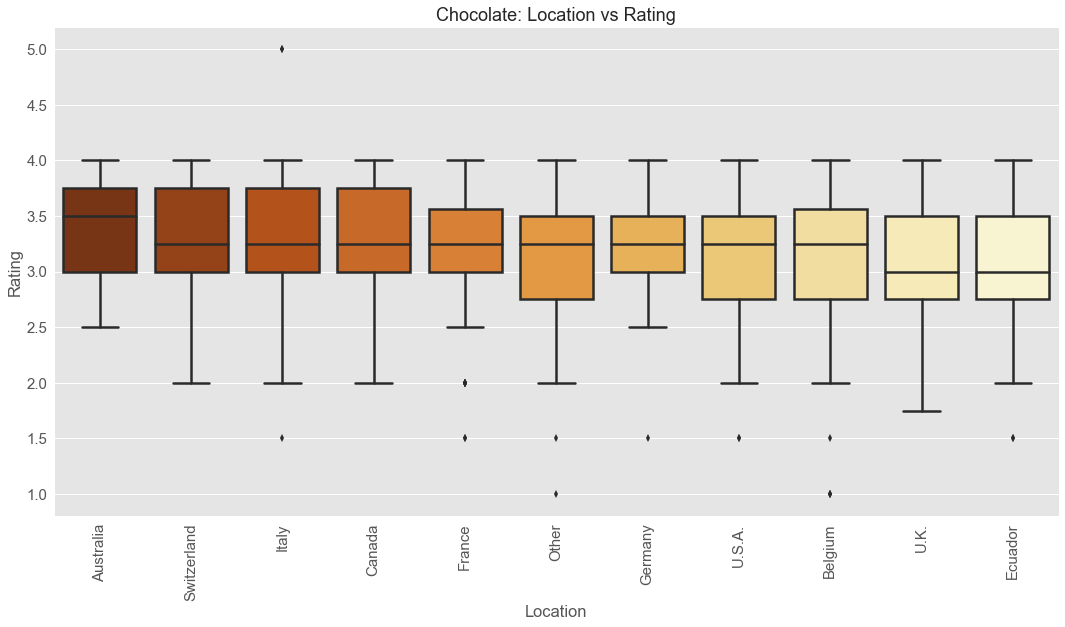

In [52]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = plt.subplots(figsize=(18, 9))
g = sns.boxplot(x=chocolate.Location, y=chocolate.Rating, palette="YlOrBr_r",
                order=chocolate[["Location","Rating"]].groupby("Location").mean().sort_values("Rating", ascending=False).index)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("Chocolate: Location vs Rating")
plt.show(g)

So the best chocolate was made by an Italian company, but Australian chocolates have the highest mean rating. But all countries produced at least one chocolate with a rating of 4.

#### Bean Type

Run an ANOVA test to see if the ratings vary by bean type

In [53]:
bean_lm = ols('Rating ~ BeanType', data=chocolate).fit()
print(bean_lm.params)
print(sm.stats.anova_lm(bean_lm, typ=2))

Intercept                    3.352041
BeanType[T.Blend-Criollo]   -0.078002
BeanType[T.Criollo]         -0.093269
BeanType[T.Forastero]       -0.238639
BeanType[T.Other]            0.078515
BeanType[T.Trinitario]      -0.103223
BeanType[T.not-specified]   -0.213527
dtype: float64
              sum_sq      df         F    PR(>F)
BeanType    8.430126     6.0  6.255778  0.000002
Residual  401.577186  1788.0       NaN       NaN


The ANOVA test shows there is a significant variation in the ratings between bean types. Visualise the differences using a Boxplot, and order the boxplots by the mean rating.

C:\Users\lynnm\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


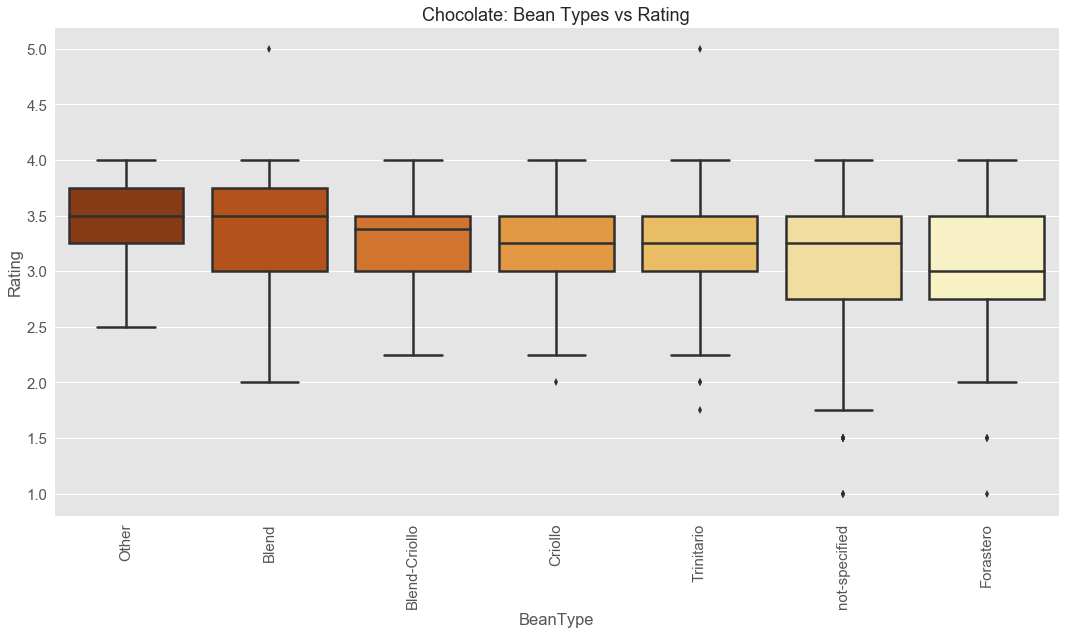

In [54]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = plt.subplots(figsize=(18, 9))
g = sns.boxplot(x=chocolate.BeanType, y=chocolate.Rating, palette="YlOrBr_r",
                order=chocolate[["BeanType","Rating"]].groupby("BeanType").mean().sort_values("Rating", ascending=False).index)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("Chocolate: Bean Types vs Rating")
plt.show(g)

#### Origin

Run an ANOVA test to see if the ratings vary by origin

In [55]:
orig_lm = ols('Rating ~ Origin', data=chocolate).fit()
print(orig_lm.params)
print(sm.stats.anova_lm(orig_lm, typ=2))

Intercept                              2.833333
Origin[T.Asia]                         0.307292
Origin[T.Belize]                       0.401361
Origin[T.Bolivia]                      0.364035
Origin[T.Brazil]                       0.451149
Origin[T.Caribbean]                    0.267276
Origin[T.Central and South America]    0.454545
Origin[T.Colombia]                     0.370155
Origin[T.Costa Rica]                   0.301282
Origin[T.Dominican Republic]           0.384122
Origin[T.Ecuador]                      0.301282
Origin[T.Ghana]                        0.213964
Origin[T.Guatemala]                    0.511494
Origin[T.Madagascar]                   0.433673
Origin[T.Mexico]                       0.175000
Origin[T.Middle Africa]                0.383333
Origin[T.Nicaragua]                    0.366667
Origin[T.Oceania]                      0.395833
Origin[T.Papua New Guinea]             0.468992
Origin[T.Peru]                         0.310562
Origin[T.Tanzania]                     0

Again there is a significant difference here. Where do the best beans come from?

C:\Users\lynnm\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


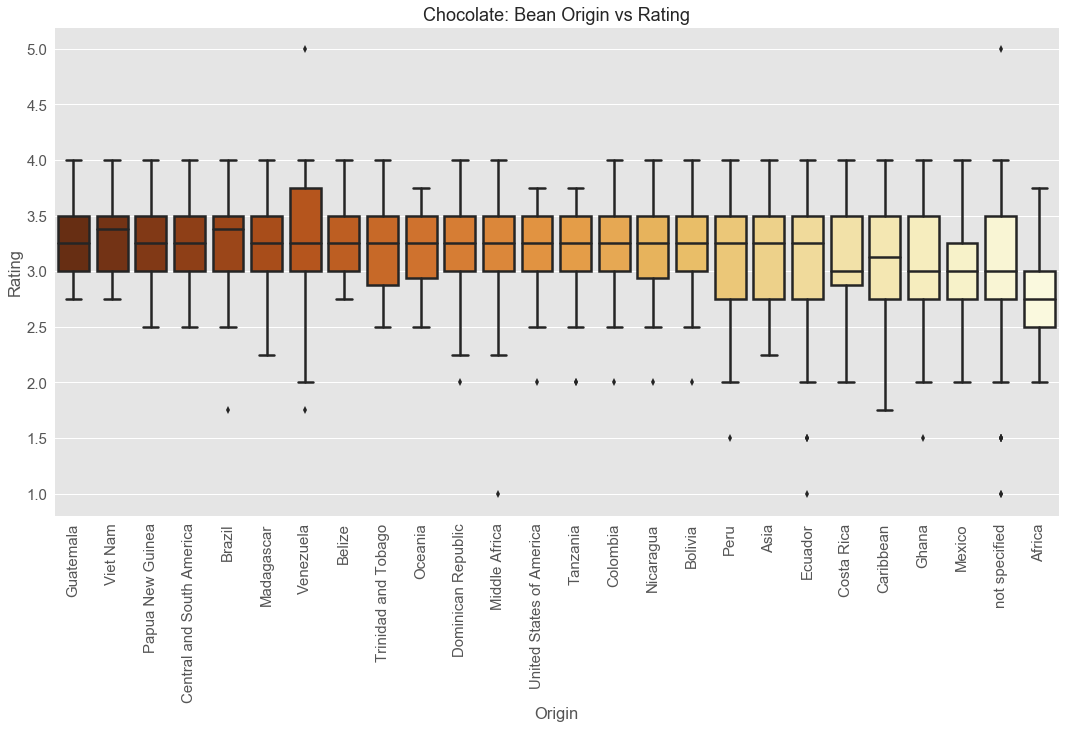

In [56]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
g = plt.subplots(figsize=(18, 9))
g = sns.boxplot(x=chocolate.Origin, y=chocolate.Rating, palette="YlOrBr_r",
                order=chocolate[["Origin","Rating"]].groupby("Origin").mean().sort_values("Rating", ascending=False).index)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.title("Chocolate: Bean Origin vs Rating")
plt.show(g)

So the beans in the best chocolate came from Venezuela (and one of unknown origin). Chocolate made from Guatemalan beans had the highest average (mean) rating and beans from Viet Nam had the highest median rating, but a significant number of Venezuelan beans rated well (the upper quartile is 3.75).

### Dependencies between Attributes

In [57]:
print("Contingency Tests for Categorical attributes")
print("Company and Location: {}".format(chi2_contingency(pd.crosstab(chocolate.Company,chocolate.Location))[1]))
print("Company and BeanType: {}".format(chi2_contingency(pd.crosstab(chocolate.Company,chocolate.BeanType))[1]))
print("Company and Origin: {}".format(chi2_contingency(pd.crosstab(chocolate.Company,chocolate.Origin))[1]))
print("Location and BeanType: {}".format(chi2_contingency(pd.crosstab(chocolate.Location,chocolate.BeanType))[1]))
print("Location and Origin: {}".format(chi2_contingency(pd.crosstab(chocolate.Location,chocolate.Origin))[1]))
print("BeanType and Origin: {}".format(chi2_contingency(pd.crosstab(chocolate.BeanType,chocolate.Origin))[1]))

Contingency Tests for Categorical attributes
Company and Location: 0.0
Company and BeanType: 4.128677032806592e-21
Company and Origin: 2.5095806921431755e-28
Location and BeanType: 2.7035570984995796e-36
Location and Origin: 5.791661572952451e-120
BeanType and Origin: 0.0


These are all significant, so there are no dependencies between any of the categorical attributes

In [58]:
print("ANOVA tests between CocoaPercent and categorical attributes")
print(sm.stats.anova_lm(ols('CocoaPercent ~ Company', data=chocolate).fit(), typ=2))
print(sm.stats.anova_lm(ols('CocoaPercent ~ Location', data=chocolate).fit(), typ=2))
print(sm.stats.anova_lm(ols('CocoaPercent ~ BeanType', data=chocolate).fit(), typ=2))
print(sm.stats.anova_lm(ols('CocoaPercent ~ Origin', data=chocolate).fit(), typ=2))

ANOVA tests between CocoaPercent and categorical attributes
            sum_sq      df         F        PR(>F)
Company   0.320959    11.0  7.592843  6.528694e-13
Residual  6.851781  1783.0       NaN           NaN
            sum_sq      df        F    PR(>F)
Location  0.110889    10.0  2.80133  0.001902
Residual  7.061851  1784.0      NaN       NaN
            sum_sq      df         F    PR(>F)
BeanType  0.010105     6.0  0.420415  0.865825
Residual  7.162635  1788.0       NaN       NaN
           sum_sq      df         F    PR(>F)
Origin    0.18631    25.0  1.886984  0.005095
Residual  6.98643  1769.0       NaN       NaN


Again these are all significant, so CocoaPercent is independent of all the categorical attributes

So there are no dependencies between the attributes that need to be considered when building a model.

## Predict Rating

### Create Test and Training sets

Randomly select 20% of the data and set aside as the test data

In [59]:
random.seed(12345)
testSize = len(chocolate) // 5
testIndices = random.sample(range(len(chocolate)),testSize)
testIndices.sort()
chocTest = chocolate.iloc[testIndices,]
print("Test data set has {} observations and {} attributes".format(chocTest.shape[0],chocTest.shape[1]))

Test data set has 359 observations and 6 attributes


The rest of the data is used to train the models

In [60]:
chocTrain = chocolate.drop(testIndices)
print("Training data set has {} observations and {} attributes".format(chocTrain.shape[0],chocTrain.shape[1]))

Training data set has 1436 observations and 6 attributes


Many of the models expect all the attributes to be numeric, so convert the categorical features to dummy variables

In [61]:
trainX = pd.get_dummies(chocTrain.iloc[:,1:])
trainY = chocTrain.Rating
print("Training data set has {} observations and {} attributes".format(trainX.shape[0],trainX.shape[1]))
testX = pd.get_dummies(chocTest.iloc[:,1:])
testY = chocTest.Rating
print("Test data set has {} observations and {} attributes".format(testX.shape[0],testX.shape[1]))

Training data set has 1436 observations and 57 attributes
Test data set has 359 observations and 57 attributes


### Linear Regression

Fit a linear regression model using ols

In [62]:
olsModel = ols('Rating ~ CocoaPercent + BeanType + Origin + Location + Company', data=chocTrain).fit()
print(olsModel.params)

Intercept                              3.978889
BeanType[T.Blend-Criollo]             -0.127241
BeanType[T.Criollo]                   -0.094194
BeanType[T.Forastero]                 -0.182481
BeanType[T.Other]                      0.064602
BeanType[T.Trinitario]                -0.107981
BeanType[T.not-specified]             -0.175294
Origin[T.Asia]                         0.363328
Origin[T.Belize]                       0.460789
Origin[T.Bolivia]                      0.444214
Origin[T.Brazil]                       0.516620
Origin[T.Caribbean]                    0.241644
Origin[T.Central and South America]    0.571485
Origin[T.Colombia]                     0.466999
Origin[T.Costa Rica]                   0.389985
Origin[T.Dominican Republic]           0.470072
Origin[T.Ecuador]                      0.422541
Origin[T.Ghana]                        0.261321
Origin[T.Guatemala]                    0.524113
Origin[T.Madagascar]                   0.419675
Origin[T.Mexico]                       0

### Linear Regression with Ridge Regularisation

I'm using Bayesian Ridge regularisation, this doesn't require setting a grid to determine the degree of regularisation to use.

In [63]:
reg = linear_model.BayesianRidge()
reg.fit(trainX,trainY)
reg.coef_

array([-0.21533339, -0.01967717,  0.10574355,  0.07362328, -0.1179921 ,
        0.03221387,  0.02971701,  0.02285368, -0.06222068, -0.01135875,
        0.10458138,  0.03650209, -0.19398617,  0.11716163, -0.02200556,
        0.06508869, -0.07414489, -0.03974912, -0.00384928,  0.06691723,
        0.02427378, -0.02449856, -0.08239347, -0.02680044,  0.05092918,
       -0.00441281,  0.01310821, -0.07633348,  0.06962656,  0.0079542 ,
       -0.06087185, -0.2130741 , -0.01095459,  0.03352354,  0.04218739,
        0.0916416 , -0.11422886,  0.09658915,  0.04960652,  0.00347252,
        0.06607764,  0.0028657 , -0.08034774,  0.07613025,  0.02095496,
       -0.05316025,  0.06021381, -0.0024517 , -0.0170175 ,  0.06979796,
       -0.00079707, -0.0102384 ,  0.0088952 ,  0.03384602,  0.01669148,
        0.05012541, -0.22034894])

Quickly check a few training predictions to see how they compare

In [64]:
lrResults = pd.DataFrame(trainY[0:10])
lrResults["Ols"] = round(olsModel.predict(chocTrain.iloc[0:10])*4)/4
lrResults["Reg"] = np.round(reg.predict(trainX.iloc[0:10])*4)/4
lrResults

,Rating,Ols,Reg
0,3.75,3.50,3.25
1,2.75,2.75,3.00
2,3.00,2.75,3.00
3,3.50,2.75,3.00
5,2.75,3.25,3.25
8,3.75,3.25,3.25
9,4.00,3.25,3.25
10,2.75,3.50,3.25
11,3.00,3.25,3.25
12,3.25,3.25,3.25


This doesn't look great, so try a few other methods. I'll evaluate these properly using the test data later.

### Decision Tree

In [65]:
dtrModel = tree.DecisionTreeRegressor(max_depth=5)
dtrModel.fit(trainX,trainY)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

Function to display the decision tree (from a KDNuggets post by Matthew Mayo, https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html)

In [66]:
def tree_to_code(tree, feature_names):

    '''
    Outputs a decision tree model as a Python function
    
    Parameters:
    -----------
    tree: decision tree model
        The decision tree to represent as a function
    feature_names: list
        The feature names of the dataset used for building the decision tree
    '''

    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

Display the decision tree

In [67]:
tree_to_code(dtrModel,trainX.columns)

def tree(CocoaPercent, Company_A. Morin, Company_Arete, Company_Bonnat, Company_Coppeneur, Company_Domori, Company_Felchlin, Company_Fresco, Company_Guittard, Company_Pralus, Company_Soma, Company_Valrhona, Company_other, Location_Australia, Location_Belgium, Location_Canada, Location_Ecuador, Location_France, Location_Germany, Location_Italy, Location_Other, Location_Switzerland, Location_U.K., Location_U.S.A., BeanType_Blend, BeanType_Blend-Criollo, BeanType_Criollo, BeanType_Forastero, BeanType_Other, BeanType_Trinitario, BeanType_not-specified, Origin_Africa, Origin_Asia, Origin_Belize, Origin_Bolivia, Origin_Brazil, Origin_Caribbean, Origin_Central and South America, Origin_Colombia, Origin_Costa Rica, Origin_Dominican Republic, Origin_Ecuador, Origin_Ghana, Origin_Guatemala, Origin_Madagascar, Origin_Mexico, Origin_Middle Africa, Origin_Nicaragua, Origin_Oceania, Origin_Papua New Guinea, Origin_Peru, Origin_Tanzania, Origin_Trinidad and Tobago, Origin_United States of America, Or

Can we improve this using a grid search to tune the model parameters?

In [68]:
random.seed(8765)

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [8, 10, 12],
    'max_features': [8, 9, 10],
    'min_samples_leaf': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16],
    'splitter': ['best', 'random']
}
# Create a based model
dtr = tree.DecisionTreeRegressor(max_depth=5)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = dtr, param_grid = param_grid, 
                           cv = 10, n_jobs = -1, verbose = 2)
grid_search.fit(trainX, trainY)
bestDtr = grid_search.best_estimator_
grid_search.best_params_

Fitting 10 folds for each of 720 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 4128 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed:   10.1s finished


{'max_depth': 8,
 'max_features': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 12,
 'splitter': 'best'}

Again, display the decision tree

In [69]:
tree_to_code(bestDtr,trainX.columns)

def tree(CocoaPercent, Company_A. Morin, Company_Arete, Company_Bonnat, Company_Coppeneur, Company_Domori, Company_Felchlin, Company_Fresco, Company_Guittard, Company_Pralus, Company_Soma, Company_Valrhona, Company_other, Location_Australia, Location_Belgium, Location_Canada, Location_Ecuador, Location_France, Location_Germany, Location_Italy, Location_Other, Location_Switzerland, Location_U.K., Location_U.S.A., BeanType_Blend, BeanType_Blend-Criollo, BeanType_Criollo, BeanType_Forastero, BeanType_Other, BeanType_Trinitario, BeanType_not-specified, Origin_Africa, Origin_Asia, Origin_Belize, Origin_Bolivia, Origin_Brazil, Origin_Caribbean, Origin_Central and South America, Origin_Colombia, Origin_Costa Rica, Origin_Dominican Republic, Origin_Ecuador, Origin_Ghana, Origin_Guatemala, Origin_Madagascar, Origin_Mexico, Origin_Middle Africa, Origin_Nicaragua, Origin_Oceania, Origin_Papua New Guinea, Origin_Peru, Origin_Tanzania, Origin_Trinidad and Tobago, Origin_United States of America, Or

And a quick comparison of the results

In [70]:
dtResults = pd.DataFrame(trainY[0:20])
dtResults["First"] = np.round(dtrModel.predict(trainX.iloc[0:20])*4)/4
dtResults["Tuned"] = np.round(bestDtr.predict(trainX.iloc[0:20])*4)/4
dtResults

,Rating,First,Tuned
0,3.75,3.25,3.50
1,2.75,3.00,3.00
2,3.00,3.00,3.00
3,3.50,3.00,3.00
5,2.75,3.25,3.50
8,3.75,3.25,3.50
9,4.00,3.25,3.50
10,2.75,3.25,3.50
11,3.00,3.25,3.50
12,3.25,3.25,3.50


There's not a lot of difference between the two models, and they only match the observed rating in a few cases.

### Random Forest

Can we improve on the decision tree using a random forest?

To select the random forest parameters, I'll use a randomised search to get rough estimates, then refine these using a grid search. This is based on the technique and code given in a blog by William Koehrsen (https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

Note: this cell takes a while to run (15 minutes on my PC)

In [71]:
random.seed(2468)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 10 fold cross validation, 
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100,
                               cv = 10, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(trainX, trainY)
bestrf_random = rf_random.best_estimator_
rf_random.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 13.0min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 2000}

In [72]:
random.seed(2468)
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [15, 20, 25],
    'max_features': [6, 8, 10],
    'min_samples_leaf': [2],
    'min_samples_split': [10],
    'n_estimators': [800, 1000, 1200]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)
rf_grid.fit(trainX, trainY)
bestrf_grid = rf_grid.best_estimator_
rf_grid.best_params_

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  1.4min finished


{'bootstrap': True,
 'max_depth': 15,
 'max_features': 8,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 1200}

How does this compare to our decision trees?

In [73]:
dtResults["RF"] = np.round(bestrf_grid.predict(trainX.iloc[0:20])*4)/4
dtResults

,Rating,First,Tuned,RF
0,3.75,3.25,3.50,3.50
1,2.75,3.00,3.00,3.00
2,3.00,3.00,3.00,3.00
3,3.50,3.00,3.00,3.00
5,2.75,3.25,3.50,3.25
8,3.75,3.25,3.50,3.25
9,4.00,3.25,3.50,3.50
10,2.75,3.25,3.50,3.25
11,3.00,3.25,3.50,3.25
12,3.25,3.25,3.50,3.25


This may have helped a little. Again the real test will come later, when I evaluate the models using the test data.

### SVM

Finally, I'll try an SVM model, again using cross-validation to select parameters for a support vector machine model, and fit the training data

Note: This cell takes over 5 mins to run.

In [74]:
random.seed(97531)
param_grid = {
    'C': [0.01, 0.1, 1.0],
    'epsilon': [0.01, 0.1, 1.0],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': [0.01, 0.1, 1],
    'coef0': [-1, 0, 1]
}
svr = SVR()
svmGrid = GridSearchCV(estimator = svr, param_grid = param_grid, 
                           cv = 10, n_jobs = -1, verbose = 2)
svmGrid.fit(trainX, trainY)
best_svr = svmGrid.best_estimator_
svmGrid.best_params_

Fitting 10 folds for each of 972 candidates, totalling 9720 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 685 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 1517 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 2789 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 3873 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 5342 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 6939 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 8454 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 9720 out of 9720 | elapsed:  5.5min finished


{'C': 0.01,
 'coef0': 1,
 'degree': 4,
 'epsilon': 0.1,
 'gamma': 0.1,
 'kernel': 'poly'}

### Test the Models

#### Baseline using Mean Rating

A baseline prediction is to simply use the mean rating of the training data rounded to the next 0.25, as the prediction for each test case.

In [75]:
meanTrain = np.round(trainY.mean()*4)/4
print("Baseline prediction using training mean\nRMSE: {:5.3}".format(math.sqrt(((testY - meanTrain) ** 2).mean())))

Baseline prediction using training mean
RMSE: 0.494


So a model has to have RMSE less than 0.494 to be better than guessing

In [76]:
testResults = pd.DataFrame(["ols","reg","dtr","dtr_tuned","rf","svm"])
testResults.columns = ["model"]
testResults["test"] = [0,0,0,0,0,0]
testResults["train"] = [0,0,0,0,0,0]
testResults

,model,test,train
0,ols,0,0
1,reg,0,0
2,dtr,0,0
3,dtr_tuned,0,0
4,rf,0,0
5,svm,0,0


In [77]:
def rmse(predict, labels):
    return math.sqrt(((predict-labels)**2).mean())

In [78]:
testResults.loc[0,"test"] = rmse(np.round(olsModel.predict(chocTest)*4)/4, testY)
testResults.loc[0,"train"] = rmse(np.round(olsModel.predict(chocTrain)*4)/4, trainY)
testResults.loc[1,"test"] = rmse(np.round(reg.predict(testX)*4)/4, testY)
testResults.loc[1,"train"] = rmse(np.round(reg.predict(trainX)*4)/4, trainY)
testResults.loc[2,"test"] = rmse(np.round(dtrModel.predict(testX)*4)/4, testY)
testResults.loc[2,"train"] = rmse(np.round(dtrModel.predict(trainX)*4)/4, trainY)
testResults.loc[3,"test"] = rmse(np.round(bestDtr.predict(testX)*4)/4, testY)
testResults.loc[3,"train"] = rmse(np.round(bestDtr.predict(trainX)*4)/4, trainY)
testResults.loc[4,"test"] = rmse(np.round(bestrf_grid.predict(testX)*4)/4, testY)
testResults.loc[4,"train"] = rmse(np.round(bestrf_grid.predict(trainX)*4)/4, trainY)
testResults.loc[5,"test"] = rmse(np.round(best_svr.predict(testX)*4)/4, testY)
testResults.loc[5,"train"] = rmse(np.round(best_svr.predict(trainX)*4)/4, trainY)
testResults

,model,test,train
0,ols,0.462184,0.447009
1,reg,0.470028,0.450935
2,dtr,0.477925,0.440289
3,dtr_tuned,0.482276,0.449437
4,rf,0.441966,0.406200
5,svm,0.469472,0.451032


All the models give a slightly better result on the training data than the test data, and so overfit slightly. The random forest model gives the best result on the test data, with an RMSE of 0.443. The default model (guess the mean rating) had an RMSE of 0.494, so we've improved the predictions by about 10%.

### The Predictions

Compare the predicted and actual ratings for the test data ...

In [79]:
results = pd.DataFrame(testY)
results["Predict"] = np.round(bestrf_grid.predict(testX)*4)/4
results["Error"] = np.abs(results.Rating - results.Predict)
results

,Rating,Predict,Error
4,3.50,3.50,0.00
6,3.50,3.25,0.25
7,3.50,3.25,0.25
13,3.75,3.25,0.50
19,3.50,3.50,0.00
20,4.00,3.50,0.50
23,3.75,3.00,0.75
26,3.25,3.25,0.00
28,3.50,3.25,0.25
31,3.00,3.25,0.25


... and summarise the result by the error.

In [80]:
results[['Error', 'Predict']].groupby(['Error']).count().reset_index()


,Error,Predict
0,0.00,76
1,0.25,134
2,0.50,100
3,0.75,36
4,1.00,8
5,1.25,4
6,1.50,1


The model predicted 77 ratings accurately (about 21%), another 133 (37%) were out by 0.25 and 99 (28%) out by 0.5. Only 13 (less than 4%) were out by a whole rating or more.